In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

/home/guillaume/anaconda3/lib/python3.7/site-packages/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.4     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from LowerLevel.pdhg import pdhg

#Upper level imports
import time
from UpperLevel.LBFGSB import *
from UpperLevel.cost_utils import *

### Creation of Lower level tools
Creating fourier_op, linear_op and param.

In [3]:
n = 50

n_rad = int( n/2 )
n_ang = int( n*np.pi )

#num_blocks = ( n_rad - 1 ) * n_ang + 1 # for sampling isolated points
num_blocks = n_ang # for choosing radia
#num_blocks = n_rad # for choosing circles
nb_samples = int( num_blocks * 2 / np.pi )

phi = np.linspace( 0, 2 * np.pi, n_ang, endpoint = False )
rad = np.linspace( 0.5 / n_rad, 0.5, (n_rad-1), endpoint = False )
Rad, Phi = np.meshgrid( rad, phi )

X = ( Rad * np.cos( Phi ) ).flatten( 'C' )
Y = ( Rad * np.sin( Phi ) ).flatten( 'C' )

full_kspace_loc = np.stack( ( X, Y ), axis = 1 )  
full_kspace_loc = np.vstack( ( np.array( [ 0, 0 ] ), full_kspace_loc ) )

m = convert_locations_to_mask(full_kspace_loc,(n,n))
fourier_op = NonCartesianFFT(samples=full_kspace_loc, shape=(n,n),implementation='cpu')

/home/guillaume/anaconda3/lib/python3.7/site-packages/mri/operators/fourier/utils.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [4]:
#Wavelet
wavelet_name = "sym8"
wavelet_scale = 1
linear_op = WaveletN(wavelet_name=wavelet_name,nb_scale=wavelet_scale,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"epsilon":1e-3,"gamma":1e-10}

### Initializing upper level
Creating images, kspace_data and updating param

In [5]:
#Oasis image
all_images = [ "oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii"]
im = nib.load("oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii")
im = im.get_fdata()

Nimages = 3
images = [(1+0j)*im[ :, 30:206, i ]for i in range(124,124+Nimages)]

In [6]:
def reduce_img_size( n_dim, image ):
    mid = image.shape[ 0 ] // 2
    f_coef = np.fft.fftshift( np.fft.fft2( image ) )
    reduced_coef = f_coef[ mid - n_dim // 2: mid + n_dim // 2, mid - n_dim // 2: mid + n_dim // 2 ]
    reduced_image = np.fft.ifft2( np.fft.fftshift( reduced_coef ) )
    return np.abs( reduced_image )

images = [reduce_img_size(n,im) for im in images]
kspace_data = [(1+0j)*fourier_op.op(u0_mat) + 
               0.14*np.mean(u0_mat)*np.random.randn(2*(n_rad-1)*n_ang+2).view(np.complex128) 
               for u0_mat in images]

In [7]:
param["c"] = 1e-8
param["beta"] = 1e-6

In [8]:
# -- Main object to learn mask --
# -------------------------------
obj = Mask_Learner(images=images , kspace_data=kspace_data , param = param ,
                    samples= np.array(full_kspace_loc) , wavelet_name = wavelet_name ,
                    wavelet_scale = wavelet_scale , verbose=-1 , const={"sigma":0.5,"tau":1} , n_rad = n_rad)

In [9]:
ptot = np.ones(n_ang*(n_rad-1)+2)
ptot[-1] = 30
uk, norms = pdhg(kspace_data[0] , ptot , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
print(ssim(uk, images[0]))

/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:19: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


0.9225808817290335


## Learning points

In [10]:
p0 = np.random.rand(n_ang*(n_rad-1)+2)
p0[-1] = 1e-3

print("Penalty:",P(p0,param["beta"]))
print("Total energy:",E(pk = p0 , images = images , kspace_data = kspace_data , param = param , 
       mask_type = "radial" , samples= np.array(full_kspace_loc) , wavelet_name = wavelet_name , 
       wavelet_scale = wavelet_scale ,verbose = -1 , const = obj.const))

Penalty: 0.0019085822227010156
Total energy: 24.806091253229983


In [11]:
pf,energy_upper,alphas = obj.optimize(p0=p0 , mask_type = "radial" , parallel = True , parallel_verbose = 1)

Multithread: True


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.2s finished



1 iterations: E(p)=2.4653970979761604, alpha=0.0005018860316539025




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.5s finished



2 iterations: E(p)=2.290000014214734, alpha=1.0765163659757524




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   50.4s finished



3 iterations: E(p)=1.9677741162327607, alpha=3.678170990299521




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished



4 iterations: E(p)=1.734315630425734, alpha=6.718040455751897




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished



5 iterations: E(p)=1.5820239970911258, alpha=10.51205050715064




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished



6 iterations: E(p)=1.455939898986291, alpha=15.600644289580856




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished



7 iterations: E(p)=1.3756963244837972, alpha=22.085274360196163




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished



8 iterations: E(p)=1.3395670455777688, alpha=27.84754322157479




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished



9 iterations: E(p)=1.3380284716091115, alpha=37.501356560123064




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished



10 iterations: E(p)=1.3376033441387802, alpha=40.2588126143083



FINISHED IN 2231.4106574058533 SECONDS



22.03312503990438 1.3376033441387802


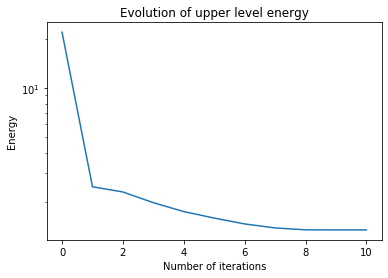

In [12]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Upper_radial/low_pen/convergence.png")

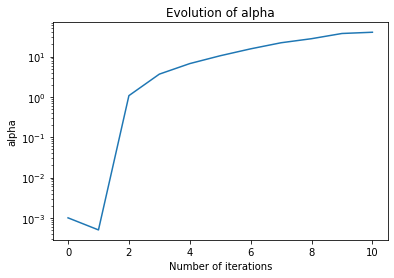

In [13]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Upper_radial/low_pen/alpha.png")

In [16]:
ptot = np.ones((n_rad-1)*n_ang+2)
ptot[-1] = pf[-1]
print("Penalty:",P(pf,param["beta"]))
print("Total energy:",energy_upper[-1])

Penalty: 0.0020199362955842432
Total energy: 1.3376033441387802


In [17]:
# -- Compute mean ssim of final mask and its ceiled version --
ceiled_pf = np.where(pf>0.5,1,0)
ceiled_pf[-1]=pf[-1]

mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")


Mean ssim: 0.9312171970818998
Mean ssim ceiled mask:0.9106696871344845


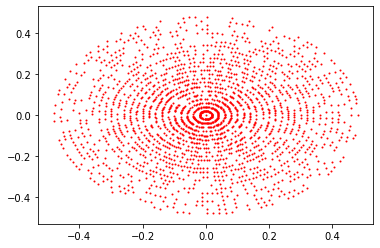

In [18]:
ceiled_mask = []
for i in range(len(pf)-1):
    if ceiled_pf[i]==1:
        ceiled_mask.append(full_kspace_loc[i])
ceiled_mask = np.array(ceiled_mask)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(ceiled_mask[:,0], ceiled_mask[:,1], s=1, c='r')
#plt.savefig("Results/Upper Level/Radial_CO/final_mask.png")

Text(0.5, 1.0, 'Histogram of $p_i$')

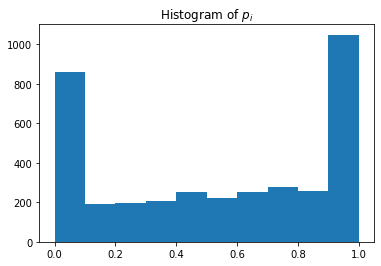

In [19]:
plt.hist(pf[:-1])
plt.title(r"Histogram of $p_i$")
#plt.savefig("Results/Upper Level/Other pen/Modified pen/histogram.png")

# Radial Center-Out mask

In [20]:
from UpperLevel.parametrisation import *
l0 = np.random.rand(n_ang+2)
l0[-1] = 1e-3
p0 = pradCO(l0,n_rad)

m = []
for i in range(len(p0)-1):
    if p0[i]>0.5:m.append(full_kspace_loc[i])
#pysap.Image(data = convert_locations_to_mask(np.array(m),(n,n))).show()

In [21]:
lf,energy_upper,alphas = obj.optimize(l0=l0 , mask_type = "radial_CO" , parallel = True , parallel_verbose = 1)

Multithread: True


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.1s finished



1 iterations: E(p)=2.3585202419104285, alpha=0.554493957304842




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



FINISHED IN 706.6847221851349 SECONDS



[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.6s finished


2.891433529272072 2.3585202419104285


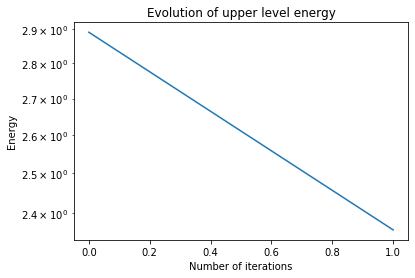

In [22]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Radial_CO/convergence.png")

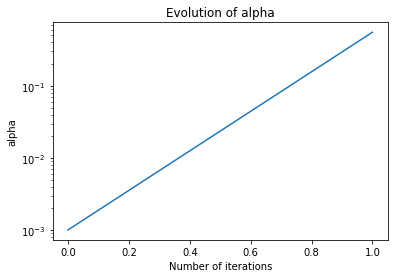

In [23]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Radial_CO/alpha.png")

0.554493957304842


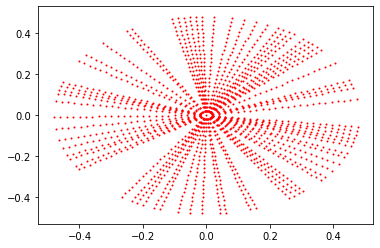

In [24]:
print(lf[-1])
pf = pradCO(lf,n_rad)
ceiled_pf = np.where(pf>0.5,1,0)
ceiled_pf[-1]=pf[-1]

ceiled_mask = []
for i in range(len(pf)-1):
    if ceiled_pf[i]==1:
        ceiled_mask.append(full_kspace_loc[i])
ceiled_mask = np.array(ceiled_mask)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(ceiled_mask[:,0], ceiled_mask[:,1], s=1, c='r')
#plt.savefig("Results/Upper Level/Radial_CO/final_mask.png")

In [25]:
ptot = np.ones((n_rad-1)*n_ang+2)
ptot[-1] = pf[-1]
print("Penalty:",P(pf,param["beta"]))
print("Total energy:",energy_upper[-1])

Penalty: 0.0017900083567674696
Total energy: 2.3585202419104285


In [26]:
# -- Compute mean ssim of final mask and its ceiled version --
mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")

/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))
/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:19: RuntimeWarning: invalid value encountered in subtract
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))



Mean ssim: 0.9026728511145148
Mean ssim ceiled mask:0.8420413544176816
